<a href="https://colab.research.google.com/github/Salva4/43__country_guess_by_image/blob/main/20230119_Endevinar_pa%C3%ADs_AND_AUS_ARG_BGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Country prediction by image
## Andorra / Australia / Argentina / Bangladesh

In [1]:
!unzip res.zip > null

In [ ]:
# !python3 main.py

## main.py

device: cuda
Loss_tr: 0.7929
Loss_te: 0.6299 	 Acc_te: 0.7558
Loss_tr: 0.5765
Loss_te: 0.5232 	 Acc_te: 0.8065
Loss_tr: 0.4735
Loss_te: 0.5352 	 Acc_te: 0.7967
Loss_tr: 0.3816
Loss_te: 0.5553 	 Acc_te: 0.7950
Loss_tr: 0.2898
Loss_te: 0.5262 	 Acc_te: 0.8081
Loss_tr: 0.2071
Loss_te: 0.5720 	 Acc_te: 0.8285
Loss_tr: 0.1502
Loss_te: 0.6473 	 Acc_te: 0.8235
Loss_tr: 0.1275
Loss_te: 0.6459 	 Acc_te: 0.8321
Loss_tr: 0.1179
Loss_te: 0.7363 	 Acc_te: 0.8308
Loss_tr: 0.0895
Loss_te: 0.8821 	 Acc_te: 0.8327


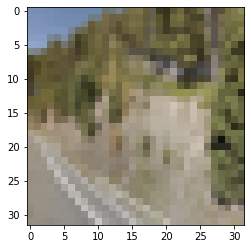

 Predicted: AND
    Target: AND
--------------------------------------------------


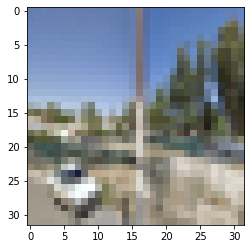

 Predicted: AUS
    Target: AUS
--------------------------------------------------


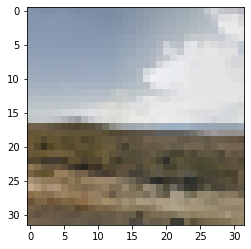

 Predicted: ARG
    Target: ARG
--------------------------------------------------


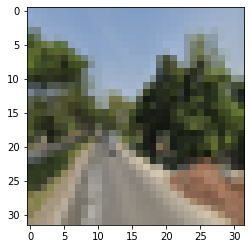

 Predicted: BGD
    Target: BGD
--------------------------------------------------


In [18]:
## Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Pytorch
import torch
import torch.nn as nn
from torchvision.transforms import transforms

## Others
import os
from PIL import Image
import random

## Parameters
COUNTRIES = 'AND AUS ARG BGD'.split()
PROP_TR = .8

## Paths
path_imgs = 'res/imgs'

## Classes and functions
class CNN(nn.Module):
  def __init__(self, dim_out):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)    # inp_sz = (32, 32)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 32, 3)
    self.fc1 = nn.Linear(26*26*32, 256)
    self.fc2 = nn.Linear(256, dim_out)
    self.dropout1 = nn.Dropout(p=.05)
    self.dropout2 = nn.Dropout(p=.05)
    self.dropout3 = nn.Dropout(p=.05)
    self.dropout4 = nn.Dropout(p=.05)

  def forward(self, x):                       # (16,  3, 32, 32)
    ## Conv
    x = self.dropout1(self.conv1(x).relu())   # (16, 32, 30, 30)
    x = self.dropout2(self.conv2(x).relu())   # (16, 32, 28, 28)
    x = self.dropout3(self.conv3(x).relu())   # (16, 32, 26, 26)

    ## MLP
    x = x.reshape(x.shape[0], -1)             # (16,    21632)
    x = self.dropout4(self.fc1(x).relu())     # (16,      256)
    x = self.fc2(x)                           # (16, #classes)

    return x

def ds_(dev):
  ds = []
  for i, country in enumerate(COUNTRIES):
    path = f'{path_imgs}/{country}'
    for fn in os.listdir(path):
      if fn == ".DS_Store": continue
      fn = f'{path}/{fn}'
      img = Image.open(fn)
      tensor = transforms.ToTensor()(img)[:3].to(dev)
      label = torch.tensor(i, dtype=torch.long).to(dev)
      ds.append((tensor, label))

  n = len(ds)
  random.shuffle(ds)
  ds_tr, ds_te = ds[:int(PROP_TR*n)], ds[int(PROP_TR*n):]
  ds_dict = dict(zip(('tr', 'te'), (ds_tr, ds_te)))
  return ds_dict

def dl_(ds):
  config = {'batch_size': 16, 'shuffle': True, 'drop_last': False}
  dl_tr = torch.utils.data.DataLoader(ds['tr'], **config)
  dl_te = torch.utils.data.DataLoader(ds['te'], **config)
  dl_dict = dict(zip(('tr', 'te'), (dl_tr, dl_te)))
  return dl_dict

def evaluate(model, criterion, dl):
  model.eval()
  corr, tot = 0, 0
  losses = []
  for i, (inp, tgt) in enumerate(dl):
    ## Fwd
    out = model(inp)
    loss = criterion(out, tgt)
    losses.append(loss.item())

    pred = torch.argmax(out, dim=-1)
    corr += (pred == tgt).sum()
    tot += pred.shape[0]

  acc_te = (corr/tot)
  print(f'Loss_te: {np.mean(losses) :.4f} \t Acc_te: {acc_te.item() :.4f}')

def show_example(model, dl, dev):
  model.eval()
  for i, country in enumerate(COUNTRIES):
    ## Load image
    path = f'{path_imgs}/{country}'
    for fn in os.listdir(path):
      if fn == ".DS_Store": continue
      fn = f'{path}/{fn}'
      img = Image.open(fn)
      tensor = transforms.ToTensor()(img)[:3].to(dev)
      label = torch.tensor(i, dtype=torch.long).to(dev)
      break
    plt.imshow(img)
    plt.show()

    ## Predict country
    inp, tgt = tensor.unsqueeze(dim=0), label.unsqueeze(dim=0)
    out = model(inp)
    pred = torch.argmax(out, dim=-1)
    country_pred, country_tgt = COUNTRIES[pred[0].item()], COUNTRIES[tgt[0].item()]
    print(f"{'Predicted: ':>12}{country_pred}")
    print(f"{'Target: ':>12}{country_tgt}")
    print(f"-"*50)
    if i > 5: break
  # plt.show()

def train(model, optimizer, criterion, dl):
  model.train()
  losses = []
  for i, (inp, tgt) in enumerate(dl):
    ## Fwd
    out = model(inp)
    loss = criterion(out, tgt)
    losses.append(loss.item())

    ## Bwd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Loss_tr: {np.mean(losses) :.4f}')

## Main function
def main():
  dev = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f'device: {dev}')

  ds = ds_(dev)
  dl = dl_(ds)

  n_classes = len(COUNTRIES)
  epochs = 10
  lr = 1e-3

  model = CNN(n_classes).to(dev)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    train(model, optimizer, criterion, dl['tr'])
    evaluate(model, criterion, dl['te'])

  show_example(model, dl['te'], dev)

## Execution
if __name__ == '__main__':
  main()